In [1]:
# adding root folder to path
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# third-party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from modAL.models import ActiveLearner

# project import
from commons.file import save_model
from commons.data import encode_data
from commons.classifiers import get_estimator
from commons.classifiers import get_query_strategy
from commons.classifiers import initial_pool_test_split

## Loading data

In [3]:
df = pd.read_csv('../datasets/vulns-labelled.csv')

# droping unused columns
df.drop(columns=[
    'cve_id', 'readable_cve_date', 'reference',
    'readable_exploit_date', 'audience_normalized'], inplace=True)

# encoding dataset
df = encode_data(df)

df['label'].replace(
    {'LOW': 0, 'MODERATE': 1, 'IMPORTANT': 2, 'CRITICAL': 3}, inplace=True)

X = df.drop(columns='label').to_numpy()
y = df['label'].to_numpy()

In [4]:
feature_names = df.drop(columns='label').columns

## Training Clasify

In [5]:
INITIAL_SIZE = 20
TEST_SIZE = 40
NUMBER_QUERIES = 100
ENCODE_DATA = False
ESTIMATOR = 'gb'
QUERY_STRATEGY = 'entropy-sampling'

In [6]:
X_initial, X_pool, X_test, y_initial, y_pool, y_test =\
    initial_pool_test_split(X, y, INITIAL_SIZE, TEST_SIZE)

if ENCODE_DATA:
    scaler = StandardScaler().fit(np.r_[X_initial, X_pool])
    X_initial = scaler.transform(X_initial)
    X_pool = scaler.transform(X_pool)
    X_test = scaler.transform(X_test)
    
X_selected = X_initial.copy()
y_selected = y_initial.copy()

base_stimator = get_estimator(ESTIMATOR)
query_strategy = get_query_strategy(QUERY_STRATEGY)

for _ in range(NUMBER_QUERIES):
    try:
        calibrated = CalibratedClassifierCV(base_stimator, method='sigmoid', cv=5)
        calibrated.fit(X_selected, y_selected)
    except ValueError:
        try:
            calibrated = CalibratedClassifierCV(base_stimator, method='sigmoid', cv=2)
            calibrated.fit(X_selected, y_selected)
        except ValueError:
            print('Not enough samples to perform cross-validation.')

    learner = ActiveLearner(calibrated, query_strategy)

    query_idx, query_inst = learner.query(X_pool)

    X_selected = np.append(X_selected, query_inst, axis=0)
    y_selected = np.append(y_selected, y_pool[query_idx], axis=0)

    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    
calibrated = CalibratedClassifierCV(base_stimator, method='sigmoid', cv=5)
calibrated.fit(X_selected, y_selected)

CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(), cv=5)

In [7]:
y_pred = calibrated.predict(X_test)

print(f'final score: {calibrated.score(X_test, y_test):.2f}')

print(f'precision score: {precision_score(y_test, y_pred, average="weighted"):.2f}')
print(f'recall score: {recall_score(y_test, y_pred, average="weighted"):.2f}')
print(f'f1 score: {f1_score(y_test, y_pred, average="weighted"):.2f}')

final score: 0.70
precision score: 0.68
recall score: 0.70
f1 score: 0.66


## Feature analysis

In [8]:
feature_importances = pd.Series(dtype='float64')

occurrences = 0

for cls in calibrated.calibrated_classifiers_:
    importances = pd.Series(
        cls.base_estimator.feature_importances_, index=feature_names)
    
    occurrences += 1
    
    if not feature_importances.empty:
        feature_importances += importances
    else:
        feature_importances = importances
    
feature_importances /= occurrences
feature_importances = feature_importances.sort_values(ascending=False)[:10]

In [9]:
values = feature_importances.values
indexes = feature_importances.index

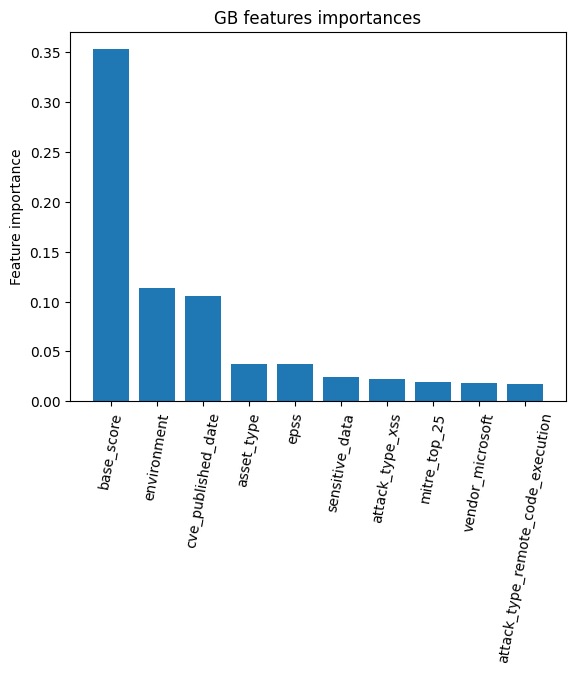

In [10]:
fig, ax = plt.subplots()

ax.bar(indexes, values)
ax.set_title(f'{ESTIMATOR.upper()} features importances')
ax.set_ylabel("Feature importance")

plt.xticks(rotation=80)
plt.show()